# Assignment 04 - Query Project

**Brad Andersen**

**W205 - Summer 2019 - Doris Schioberg**

# Introduction

Assignment 04 represents the culmination of three course projects -- "Query Project" Assignments 02, 03 and 04 -- that explore data beneath the Google BigQuery public data set _bigquery-public-data.san&#095;francisco_ .  Specifically, questions explored data in the _bikeshare&#095;trips_ table, but occasionally referenced data from table _bikeshare&#095;stations_.

The problem statement addressed across all assignments is as follows:

> **Problem Statement**
>
> You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.
>
> Through this project, you will answer these questions:
>
> * What are the 5 most popular trips that you would call "commuter trips"?
> * What are your recommendations for offers (justify based on your findings)?

Because this assignment is a continuation of prior assignments, findings and conclusions presented in this assignment leverage additional exploratory work here:

* [Assignment 02 - Query Project](https://github.com/mids-w205-schioberg/assignement-02-bdandersen-berkeley/tree/master)
* [Assignment 03 - Query Project](https://github.com/mids-w205-schioberg/assignment-03-bdandersen-berkeley/tree/master)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

# Question 1

**What are the 5 most popular trips that you would call "commuter trips"?**

## Identifying Popular Commuter Trips

Criteria defining "commuter trips" were identified in Assignment 03 (see Question 1).  Those criteria are repeated here as follows:

| Criteria | Value(s) |
| --- | --- |
| **Time(s) of day** | 7:30 - 9:30 am, 4:00 - 7:00 pm |
| **Type** | One-way |
| **Duration** | Not exceeding 30 minutes |
| **Days of week** | Monday - Friday (weekdays) |
| **Rider membership** | Subscribers |

A commuter trip -- hereafter referred to as a _commuter route_ -- is unique among all other commuter routes for its origin and destination stations, identified by columns `start_station_id` and `end_station_id` in table `bikeshare_trips`, respectively.  Note, too, that a commuter route is defined by the _direction_ of the trip; a commuter route from station 1 to 2 is _not_ the same as a route from station 2 to 1.

The following query identifies the five commuter routes that have been traveled most frequently.  A `WHERE` clause filtering results associated with commuter route criteria is introduced within the _commute&#095;criteria_ subquery so that aggregation (i.e. `GROUP BY route_token`) can be kept simple within the main SQL query.

``
WITH commute_criteria AS (
  SELECT 
    CONCAT(CAST(bt.start_station_id AS STRING), '|', CAST(bt.end_station_id AS STRING)) AS route_token,
    bt.start_station_id,
    bt.end_station_id,
    bt.start_station_name,
    bt.end_station_name,
    bs.landmark AS start_station_city
  FROM `bigquery-public-data.san_francisco.bikeshare_trips` bt
  INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs ON bt.start_station_id = bs.station_id
  WHERE 
    start_station_id != end_station_id AND
    (
      (TIME(start_date) >= TIME(7, 30, 0) AND (TIME(start_date) <= TIME(9, 30, 0))) OR
      (TIME(start_date) >= TIME(16, 0, 0) AND (TIME(start_date) <= TIME(19, 0, 0)))
    ) AND
    (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) < 7) AND
    duration_sec / 60 <= 30 AND
    UPPER(subscriber_type) = 'SUBSCRIBER'
)
SELECT 
  route_token,
  start_station_city,
  start_station_name, 
  end_station_name,
  COUNT(route_token) AS route_total
FROM commute_criteria
GROUP BY route_token, start_station_name, end_station_name, start_station_city
ORDER BY route_total DESC
LIMIT 5
``

Executing the query from the BigQuery command line results in the following:

In [2]:
! bq query --location=US --use_legacy_sql=FALSE --format=csv 'WITH commute_criteria AS (SELECT CONCAT(CAST(bt.start_station_id AS STRING), "|", CAST(bt.end_station_id AS STRING)) AS route_token, bt.start_station_id, bt.end_station_id, bt.start_station_name, bt.end_station_name, bs.landmark AS start_station_city FROM `bigquery-public-data.san_francisco.bikeshare_trips` bt INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs ON bt.start_station_id = bs.station_id WHERE start_station_id != end_station_id AND ((TIME(start_date) >= TIME(7, 30, 0) AND (TIME(start_date) <= TIME(9, 30, 0))) OR (TIME(start_date) >= TIME(16, 0, 0) AND (TIME(start_date) <= TIME(19, 0, 0)))) AND (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) < 7) AND duration_sec / 60 <= 30 AND UPPER(subscriber_type) = '"'"'SUBSCRIBER'"'"') SELECT route_token, start_station_city, start_station_name, end_station_name, COUNT(route_token) AS route_total FROM commute_criteria GROUP BY route_token, start_station_name, end_station_name, start_station_city ORDER BY route_total DESC LIMIT 5' > top_five_commute_routes.csv

top_five_commute_routes = pd.read_csv("top_five_commute_routes.csv")
top_five_commute_routes

Waiting on bqjob_r14239bdd37bb1bb3_0000016b33182e14_1 ... (0s) Current status: DONE   

route_token start_station_city                       start_station_name  \
0       61|50      San Francisco                          2nd at Townsend   
1       50|61      San Francisco     Harry Bridges Plaza (Ferry Building)   
2       60|74      San Francisco                   Embarcadero at Sansome   
3       69|65      San Francisco  San Francisco Caltrain 2 (330 Townsend)   
4       51|70      San Francisco                    Embarcadero at Folsom   

                           end_station_name  route_total  
0      Harry Bridges Plaza (Ferry Building)         4834  
1                           2nd at Townsend         4691  
2                         Steuart at Market         4633  
3                           Townsend at 7th         4515  
4  San Francisco Caltrain (Townsend at 4th)         4507

## Further Analysis

Knowing the five most popular commuter routes -- combined with the analysis performed in Assignment 03 -- is helpful when developing recommendations.  However, upon examining the distribution of routes taken totals, the following observations beg further exploration:

In [3]:
top_five_commute_routes.describe()

route_total
count     5.000000
mean   4636.000000
std     135.572859
min    4507.000000
25%    4515.000000
50%    4633.000000
75%    4691.000000
max    4834.000000

* All five popular commuter routes originate at stations located in San Francisco
* The two most popular commuter routes together represent a round trip; one's origin is the other's destination, and its destination is the other's origin
* The standard deviation (135.57 trips) represents only 2.9 percent of the mean (4636 trips).  While this calculation is of little statistical importance, it does emphasize the fact that the number of trips taken on the five most popular routes were very similar.

Additional information that might be beneficial when developing recommendations include:

* What are the 100 most popular commuter routes?  Are there similarities that might assist in the analysis?
* How do the counts of the 100 most popular commuter routes compare to the counts of the 100 most popular routes (i.e. commuter and non-commuter trips)?

Executing queries from the BigQuery comand line and capturing this data is as follows:

In [4]:
! bq query --location=US --use_legacy_sql=FALSE --max_rows=100 --format=csv 'WITH commute_criteria AS (SELECT CONCAT(CAST(bt.start_station_id AS STRING), "|", CAST(bt.end_station_id AS STRING)) AS route_token, bt.start_station_id, bt.end_station_id, bt.start_station_name, bt.end_station_name, bs.landmark AS start_station_city FROM `bigquery-public-data.san_francisco.bikeshare_trips` bt INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs ON bt.start_station_id = bs.station_id WHERE start_station_id != end_station_id AND ((TIME(start_date) >= TIME(7, 30, 0) AND (TIME(start_date) <= TIME(9, 30, 0))) OR (TIME(start_date) >= TIME(16, 0, 0) AND (TIME(start_date) <= TIME(19, 0, 0)))) AND (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) < 7) AND duration_sec / 60 <= 30 AND UPPER(subscriber_type) = '"'"'SUBSCRIBER'"'"') SELECT route_token, start_station_city, start_station_name, end_station_name, COUNT(route_token) AS route_total FROM commute_criteria GROUP BY route_token, start_station_name, end_station_name, start_station_city ORDER BY route_total DESC' > top_hundred_commute_routes.csv
! bq query --location=US --use_legacy_sql=FALSE --max_rows=100 --format=csv 'WITH commute_criteria AS (SELECT CONCAT(CAST(bt.start_station_id AS STRING), "|", CAST(bt.end_station_id AS STRING)) AS route_token, bt.start_station_id, bt.end_station_id, bt.start_station_name, bt.end_station_name, bs.landmark AS start_station_city FROM `bigquery-public-data.san_francisco.bikeshare_trips` bt INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bs ON bt.start_station_id = bs.station_id ) SELECT route_token, start_station_city, start_station_name, end_station_name, COUNT(route_token) AS route_total FROM commute_criteria GROUP BY route_token, start_station_name, end_station_name, start_station_city ORDER BY route_total DESC' > top_hundred_routes.csv

top_hundred_commute_routes = pd.read_csv("top_hundred_commute_routes.csv")
top_hundred_routes = pd.read_csv("top_hundred_routes.csv")

Waiting on bqjob_r4109487c06fe7e35_0000016b33183c63_1 ... (0s) Current status: DONE   

In [5]:
InteractiveShell.ast_node_interactivity = "all"

top_hundred_commute_routes
top_hundred_routes

route_token start_station_city  \
0        50|60      San Francisco   
1        69|65      San Francisco   
2        61|50      San Francisco   
3        50|61      San Francisco   
4        60|74      San Francisco   
5        65|69      San Francisco   
6        51|70      San Francisco   
7        70|50      San Francisco   
8        74|61      San Francisco   
9        74|70      San Francisco   
10       55|70      San Francisco   
11       50|70      San Francisco   
12       65|70      San Francisco   
13       64|77      San Francisco   
14       70|55      San Francisco   
15       67|69      San Francisco   
16       74|60      San Francisco   
17       77|64      San Francisco   
18       60|50      San Francisco   
19       69|39      San Francisco   
20       70|51      San Francisco   
21       69|57      San Francisco   
22       39|69      San Francisco   
23       70|74      San Francisco   
24       63|70      San Francisco   
25       61|74      San Francisco   
26       28|27      Mountain View   
27       76|70      San Francisco   
28       70|77      San Francisco   
29       65|72      San Francisco   
..         ...                ...   
70       82|70      San Francisco   
71       50|50      San Francisco   
72       63|69      San Francisco   
73       61|70      San Francisco   
74       48|74      San Francisco   
75       70|60      San Francisco   
76       70|54      San Francisco   
77       69|77      San Francisco   
78       49|70      San Francisco   
79       28|32      Mountain View   
80       54|60      San Francisco   
81       77|50      San Francisco   
82       67|39      San Francisco   
83       64|50      San Francisco   
84       39|70      San Francisco   
85       65|50      San Francisco   
86       70|39      San Francisco   
87       61|55      San Francisco   
88       70|56      San Francisco   
89       55|65      San Francisco   
90       54|50      San Francisco   
91       55|57      San Francisco   
92       74|54      San Francisco   
93       60|70      San Francisco   
94       77|69      San Francisco   
95       51|61      San Francisco   
96       50|69      San Francisco   
97       70|41      San Francisco   
98       70|57      San Francisco   
99       50|65      San Francisco   

                               start_station_name  \
0            Harry Bridges Plaza (Ferry Building)   
1         San Francisco Caltrain 2 (330 Townsend)   
2                                 2nd at Townsend   
3            Harry Bridges Plaza (Ferry Building)   
4                          Embarcadero at Sansome   
5                                 Townsend at 7th   
6                           Embarcadero at Folsom   
7        San Francisco Caltrain (Townsend at 4th)   
8                               Steuart at Market   
9                               Steuart at Market   
10  Temporary Transbay Terminal (Howard at Beale)   
11           Harry Bridges Plaza (Ferry Building)   
12                                Townsend at 7th   
13                              2nd at South Park   
14       San Francisco Caltrain (Townsend at 4th)   
15                                 Market at 10th   
16                              Steuart at Market   
17                              Market at Sansome   
18                         Embarcadero at Sansome   
19        San Francisco Caltrain 2 (330 Townsend)   
20       San Francisco Caltrain (Townsend at 4th)   
21        San Francisco Caltrain 2 (330 Townsend)   
22                             Powell Street BART   
23       San Francisco Caltrain (Townsend at 4th)   
24                                  Howard at 2nd   
25                                2nd at Townsend   
26                 Mountain View Caltrain Station   
27                                  Market at 4th   
28       San Francisco Caltrain (Townsend at 4th)   
29                                Townsend at 7th   
..                                            ...   
70          

### Origin Station Frequency

With respect to the hundred most popular commute routes and routes void of any selection criteria, San Francisco dominates the cities from which bike trips originate:

In [6]:
top_hundred_commute_routes.groupby(["start_station_city"])["route_token"].nunique()

start_station_city
Mountain View     4
San Francisco    92
San Jose          4
Name: route_token, dtype: int64

In [7]:
top_hundred_routes.groupby(["start_station_city"])["route_token"].nunique()

start_station_city
Mountain View     4
San Francisco    94
San Jose          2
Name: route_token, dtype: int64

### Popular Routes' Trip Count Distributions

Examining the distribution of trip counts among the hundred most popular commute routes and routes void of any selection criteria, it is apparent from each distribution's standard deviation that commute route counts are more concentrated around the mean.  When considering that this data represents the hundred most popular routes, it can be inferred that commute routes in general are more regularly traveled.

In [8]:
top_hundred_commute_routes.describe()

route_total
count   100.000000
mean   2145.300000
std     969.547437
min    1118.000000
25%    1401.250000
50%    1872.500000
75%    2587.250000
max    4834.000000

In [9]:
top_hundred_routes.describe()

route_total
count   100.000000
mean   3470.290000
std    1564.985037
min    1858.000000
25%    2341.750000
50%    2916.500000
75%    4280.750000
max    9150.000000

Text(0.5, 1.0, 'Total Trip Counts: Commute vs. All Routes\n100 Most Popular Trips')

Text(0, 0.5, 'Total Route Count')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe3fd011da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe3fd0204e0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fe3fd011b70>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe3fd020ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe3fd020ef0>,
 'means': []}

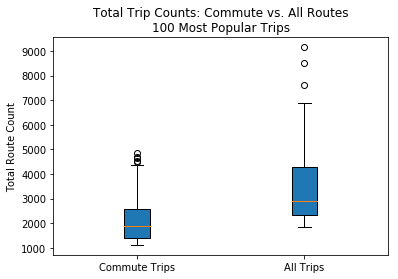

In [10]:
InteractiveShell.ast_node_interactivity = "last_expr"

route_data = {
    "Commute Trips": top_hundred_commute_routes.get_values()[:,4].astype(int),
    "All Trips": top_hundred_routes.get_values()[:,4].astype(int)
}
route_dataframe = pd.DataFrame(route_data).transpose()

fig, ax = plt.subplots()
ax.set_title("Total Trip Counts: Commute vs. All Routes\n100 Most Popular Trips")
ax.set_ylabel("Total Route Count")
ax.boxplot(route_dataframe, patch_artist = True, labels = ["Commute Trips", "All Trips"])
print()

# Question 2

**What are your recommendations for offers (justify based on your findings)?**

Considering the combined findings from Assignment 03 and Assignment 04, the following are recommendations for offers that Ford GoBike might heed in order to increase ridership:

* Bike trips that originate from San Francisco bike stations dominate lists of popular routes.  While we might expect skew in favor of San Francisco routes based upon the fact that Ford GoBike has nearly twice as many bike rental stations in San Francisco than elsewhere, data combined with common sense tells us that bike use is much greater in San Francisco than in other cities served in the Bay Area (San Jose, Mountain View, Redwood City and Palo Alto).  Therefore, **offers focusing upon routes originating in San Francisco would likely lead to increased ridership.**

* The regularity of bike trips along popular commute routes suggests that Ford GoBike bike rentals are a popular means of commute-oriented travel, particularly among bike stations located in San Francisco.  Bike rentals are more popular among riders taking one-way trips.  Therefore, **offers focusing upon commute-oriented travel (with commute routes defined in Assignment 03 and repeated above) would likely lead to increased ridership.**

* Ridership decreases during midday hours, specifically between peak commuting hours in the mornings and evenings.  Consequently, there will be a larger number of bikes available during this time.  There is evidence of increased ridership among subscribing customers over the noon hour.  Therefore, **offers during less-popular midday times -- but times when there is evidence of increased rentals -- would likely lead to increased ridership.**
